## How to make predictions with a multiple regression model




In [1]:
import pandas as pd
import seaborn as sns

## The Cars dataset

In [2]:
carsData = pd.read_csv('cars.csv')

In [3]:
carsData.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [4]:
carsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

#### =>
205 rows, 26 cols.

In [5]:
carsData['carbody'].unique()

array(['convertible', 'hatchback', 'sedan', 'wagon', 'hardtop'],
      dtype=object)

### =>
* `carsData['carbody']` is loaded as an object (textual data); but is actually a Category-- 'hatchback','sedan', etc.

This column may be useful in a regression model.

# How to create a simple regression model :
(ie, using only 1 independent variable)

* Showing the correlations of the {numeric} independent variables, with the dependent variable `price`:

<AxesSubplot:>

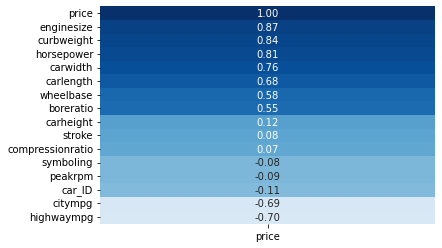

In [6]:
sns.heatmap(data=carsData.corr()[['price']].sort_values('price', ascending=False),
            annot=True, cmap='Blues', vmin=-1.0, vmax=1.0, cbar=False, fmt='.2f')

# 'df.corr()' in newer versions of Pandas, requires you to explicitly write 'numeric_only = True 
#....(or False)'. 

# Else, all the Object columns (eg: df['CarName'] = 'alfa romero giulia') will throw an error.

#### =>
* Thus, `enginesize` and `curbweight` have a high, positive correlation with the dependent variable `price`.
* `citympg` and `highwaympg` have a high, negative correlation with the dependent variable `price`.
* Variables like `carheight`, `stroke`, `compressionratio` have no correlation at all with `price`.

<br>

* When choosing independent variables for regression, choose the ones with **strong** correlation: ie [`enginesize` , `curbweight`,`citympg` , `highwaympg` ]

### =>
Creating a LR model using the variable having the strongest correlation, ie `enginesize`:

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    carsData[['enginesize']], carsData[['price']],
    test_size=0.20, random_state=20)

model = LinearRegression()
model.fit(x_train, y_train)

model.score(x_test,y_test)

0.7063964117029844

### => 
Thus, looking at the R-square value returned by `score()` on the Test dataset, `enginesize` does seem to be a good choice for the independent variable- as it explains ~70% of the variability in the dependent variable `price`.

In [9]:
model.score(x_train, y_train)

0.766524123801206

### => 
R-square value returned by `score()` on the Train dataset (~76% of the variability), almost always is higher than that on the Test dataset, as the model was already trained using data from the very same Training set. 

In [10]:
y_predicted = model.predict(x_test)

In [11]:
# create DataFrame for the price predictions
predicted_df = pd.DataFrame(y_predicted, columns=['predictedPrice'])

# combine the test data and the predicted data into a DF
final_df = predicted_df.join([x_test.reset_index(drop=True),
                        y_test.reset_index(drop=True)])
final_df[['enginesize','price','predictedPrice']].head()

,enginesize,price,predictedPrice
0,136,15250.0,14905.920686
1,90,8916.5,7164.387613
2,92,8778.0,7500.976007
3,203,31400.5,26181.631901
4,92,6488.0,7500.976007


In [13]:
# for ease of understanding within the same DF, renaming the dependent-variable's-column ['price'], as ['actualPrice']:
final_df.rename(columns = {'price':'actualPrice'}, inplace = True )
final_df = final_df[['enginesize', 'actualPrice','predictedPrice']]  # setting the order/sequence of columns
final_df.head()

,enginesize,actualPrice,predictedPrice
0,136,15250.0,14905.920686
1,90,8916.5,7164.387613
2,92,8778.0,7500.976007
3,203,31400.5,26181.631901
4,92,6488.0,7500.976007


#### # Note:
`final_df['actualPrice']` comes from `y_test`.

## How to plot the residuals of a simple regression

* How to calculate the residuals:

In [14]:
final_df['residual'] = final_df['actualPrice'] - final_df['predictedPrice']
final_df = final_df[['enginesize', 'actualPrice','predictedPrice', 'residual']]  # setting the order/sequence of columns
final_df.head(2)

,enginesize,actualPrice,predictedPrice,residual
0,136,15250.0,14905.920686,344.079314
1,90,8916.5,7164.387613,1752.112387


* How to plot the residuals with a scatterplot:

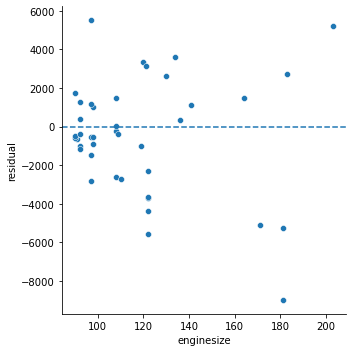

In [16]:
g = sns.relplot(data= final_df, x='enginesize', y='residual', kind='scatter')
for ax in g.axes.flat:
    ax.axhline(0, ls='--')

### =>
The horizontal line at `y=0` is where the actualPrice and predictedPrice are the same.

* How to plot the distribution of the residuals:

(using a KDE plot) = Kernel Density Estimation

<AxesSubplot:xlabel='residual', ylabel='Density'>

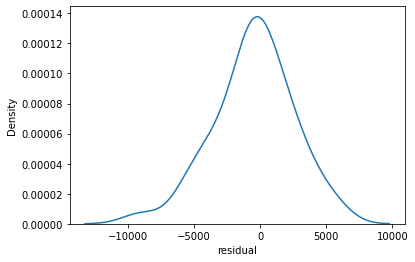

In [17]:
sns.kdeplot(data= final_df, x='residual')

#### =>
Logic: 

In a KDE plot, if : 
* the distribution of the residuals forms a bell-shaped curve along the x-axis, AND 
* a majority of the datapoints (ie, the highest point of the bell-curve) are relatively close to where  `x = 0`

==> your regression is a good fit.

<br>
<br>

Otherwise, your regression isn't a good fit, and hence, your predictions won't be good.

## ===> 
* In the above case, most of the residuals are within -5000 to +5000 of `x = 0`, but there is a wider range on the NEGATIVE side of the bell-curve.


* Now, more of the residuals occuring of the negative side of the bell curve, implies that:

for most datapoints, the result of [actualPrice - predictedPrice] is negative.

ie, `predictedPrice` is turning out to be much higher than the `actualPrice`.

ie, `predictedPrice` is being over-estimated.

<br>

This could be caused by a few cars with much higher prices 

{eg: on the right side of the curve, there is a datapoint (ie, a car) that has a $10K difference between the `actualPrice` and the `predictedPrice`}.

<br>
<br>

* Also, the scatterplot shows some outliers that are MORE THAN 5000 dollars away from `x=0`. This indicates that you may be able to improve the model by dropping such outliers.



# How to create a multiple regression model

ie, use 2/more independent variables:

In [18]:
x_train, x_test, y_train, y_test = train_test_split(
    carsData[['enginesize','curbweight']], carsData[['price']], #using the 2 dependent vars with the strongest correlation.
    test_size=0.20, random_state=20)

model = LinearRegression()
model.fit(x_train, y_train)

model.score(x_test, y_test)

0.758107274867953

#### =>
Thus, R-square value has gone up from `70%` in Simple LR, to `75%` in Multiple LR with `['enginesize','curbweight']` as the independent vars.

In [19]:
model.score(x_train, y_train)

0.7950435284247739

In [21]:
y_predicted = model.predict(x_test)
y_predicted[0:5]   # is an Array-- thus, cannot use the DF-method called 'df.head(5)'

array([[14186.97433088],
       [ 5681.24329917],
       [12256.11615716],
       [26252.38799549],
       [ 6633.72373231]])

## How to prepare and plot the multiple regression model:

In [22]:
# create the DataFrame for the price predictions
predicted_df = pd.DataFrame(y_predicted, columns=['predictedPrice'])

# combine the test data and the predicted data into a DataFrame
final_df = predicted_df.join([x_test.reset_index(drop=True),
                        y_test.reset_index(drop=True)])

# for ease of understanding within the same DF, renaming the dependent-variable's-column ['price'], as ['actualPrice']:
final_df.rename(columns = {'price':'actualPrice'}, inplace = True )
final_df = final_df[['enginesize', 'curbweight', 'actualPrice','predictedPrice']]  # setting the order/sequence of columns
final_df.head()

,enginesize,curbweight,actualPrice,predictedPrice
0,136,2507,15250.0,14186.974331
1,90,1874,8916.5,5681.243299
2,92,3110,8778.0,12256.116157
3,203,3366,31400.5,26252.387995
4,92,2015,6488.0,6633.723732


## How to plot the residuals of a multiple regression

* How to calculate the residuals:

In [23]:
final_df['residual'] = final_df['actualPrice'] - final_df['predictedPrice']
final_df.head()

,enginesize,curbweight,actualPrice,predictedPrice,residual
0,136,2507,15250.0,14186.974331,1063.025669
1,90,1874,8916.5,5681.243299,3235.256701
2,92,3110,8778.0,12256.116157,-3478.116157
3,203,3366,31400.5,26252.387995,5148.112005
4,92,2015,6488.0,6633.723732,-145.723732


* How to plot the residuals with a scatterplot:

<AxesSubplot:xlabel='residual', ylabel='Density'>

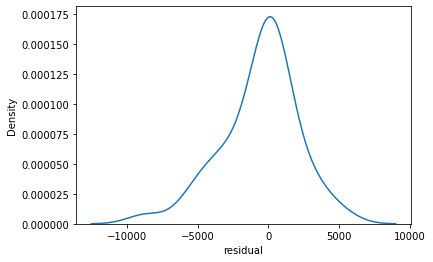

In [24]:
sns.kdeplot(data= final_df, x='residual')

## ===> 
* Again, most of the residuals are within -5000 to +5000 , and they are centred on `x = 0`.

* Also, the outliers are still affecting the regression on the negative side of the curve.
<br>
<br>

* HOWEVER:
- The curve has also COMPRESSED inwards (ie, become 'thinner' than the previous KDE plot)

.... ie, more number of predictions than before, have residuals that are closer to `x = 0`

- This indicates that the predictions improved, even though they were already fairly accurate.


In [27]:
# ***************************************************************************

In cell[5], we saw that:

* `carsData['carbody']` is loaded as an object; but is actually a Category-- 'hatchback','sedan', etc.

This column may be useful in a regression model.

<br>
<br>

* Categorical data can be stored in cols containing String values, or even containing Integer values.
* You can use such columns to create **new Categorical Variables**-- that can be used as independent variables for your Models.

#### =>
* Before you can use Categorical variables as independent variables, you need to prepare them. This includes:
1. Identifying them,
2. Reviewing them to see whether it makes sense to include them when your `fit` a model,
3. Converting them to dummy variables -- if you decide to use them,
4. Rescaling the other data, so that it will work with the dummy variables.

## How to identify categorical variables:
1) To identify the LIKELY categorical variables:
* Use `nunique()`
* Then, to identify such variables, look for columns with a LOW number of unique values.

<br>
<br>

2) To ensure that the variables picked out in Step#1 (that are LIKELY to be Categorical), indeed are:

* Use `value_counts()`: to review the Categ vars, and to determine which ones are 'well-balanced'

.
.
(Categ Vars with well-balanced values, often yield better results in regressions)


<br>
<br>

Note:

3 types of Categorical variables:
* Nominal variables:-  Have values like ["red", "yellow", "blue",...]- thus, cannot be ordered in a meaningful way.
* Ordinal variables:-  Have values like [0,1,2,3]- thus, they can be ordered in a meaningful way.
* Dichotomous variables:-  Have just 2 values like [0,1] or ["front","rear"].

In [28]:
carsData.nunique()

car_ID              205
symboling             6
CarName             147
fueltype              2
aspiration            2
doornumber            2
carbody               5
drivewheel            3
enginelocation        2
wheelbase            53
carlength            75
carwidth             44
carheight            49
curbweight          171
enginetype            7
cylindernumber        7
enginesize           44
fuelsystem            8
boreratio            38
stroke               37
compressionratio     32
horsepower           59
peakrpm              23
citympg              29
highwaympg           30
price               189
dtype: int64

### =>
* `nunique = 2` for `fueltype`, `aspiration`, `doornumber`, `eniginelocation`. Thus, most likely 'dichotomous Categorical variables'.
* `nunique = 5` for `carbody`. Thus, probably stores Categ data.


* Similarly, as  `nunique(symboling) = 6`, `nunique(drivewheel) = 3`, `nunique(enginetype) = 7`, `nunique(cylindernumber) = 7`,`nunique(fuelsystem) = 8`-- they are LIKELY to be Categ data.

## How to review categorical variables

### Dichotomous variables

In [30]:
carsData['enginelocation'].value_counts()

front    202
rear       3
Name: enginelocation, dtype: int64

In [31]:
carsData['fueltype'].value_counts()

gas       185
diesel     20
Name: fueltype, dtype: int64

In [32]:
carsData['aspiration'].value_counts()

std      168
turbo     37
Name: aspiration, dtype: int64

In [33]:
carsData['doornumber'].value_counts()

four    115
two      90
Name: doornumber, dtype: int64

### Nominal variables

In [34]:
carsData['fuelsystem'].value_counts()

mpfi    94
2bbl    66
idi     20
1bbl    11
spdi     9
4bbl     3
mfi      1
spfi     1
Name: fuelsystem, dtype: int64

In [35]:
carsData['carbody'].value_counts()

sedan          96
hatchback      70
wagon          25
hardtop         8
convertible     6
Name: carbody, dtype: int64

In [36]:
carsData['drivewheel'].value_counts()

fwd    120
rwd     76
4wd      9
Name: drivewheel, dtype: int64

In [37]:
carsData['enginetype'].value_counts()

ohc      148
ohcf      15
ohcv      13
dohc      12
l         12
rotor      4
dohcv      1
Name: enginetype, dtype: int64

In [38]:
carsData['cylindernumber'].value_counts()

four      159
six        24
five       11
eight       5
two         4
three       1
twelve      1
Name: cylindernumber, dtype: int64

### => 
* In case of this DF, the DF contains `dichotomous` and `nominal` Categ variables, but not `ordinal` Categ variables.

<br>
<br>

* NOTE:
-- When choosing Categ variables for regression analysis, try to choose vars that are **well-balanced** (ie, each category-value has a similar number of entries).
-- Eg: The cols `fuelsystem`(94 + 66 + ...) and `carbody`(96 + 70 + ...) are well-balanced.
-- But, the col `enginelocation` is poorly-balanced with (202 + 3). Thus, DO NOT choose `enginelocation` in the regression model.

<br>
<br>

Why does a Categ column being 'well-balanced' matter?
* Suppose you decide to use col `enginelocation` to create the regression model, and you use a 20% Test dataset.
* Then, there is a strong possibilty that the {3} `enginelocation == "rear" ` values, will end up in the trainingset, and none will be in the testset.

## How to create dummy variables

To create a NEW column, for each unique value of the original Categorical column:

In [39]:
categColumns = ['aspiration','doornumber','carbody','drivewheel']
dummies_df = pd.get_dummies(carsData[categColumns])
dummies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   aspiration_std       205 non-null    uint8
 1   aspiration_turbo     205 non-null    uint8
 2   doornumber_four      205 non-null    uint8
 3   doornumber_two       205 non-null    uint8
 4   carbody_convertible  205 non-null    uint8
 5   carbody_hardtop      205 non-null    uint8
 6   carbody_hatchback    205 non-null    uint8
 7   carbody_sedan        205 non-null    uint8
 8   carbody_wagon        205 non-null    uint8
 9   drivewheel_4wd       205 non-null    uint8
 10  drivewheel_fwd       205 non-null    uint8
 11  drivewheel_rwd       205 non-null    uint8
dtypes: uint8(12)
memory usage: 2.5 KB


In [42]:
carsData_numericCols_df = carsData.drop(columns= categColumns)
cars_and_Dummies_df = carsData_numericCols_df.join(dummies_df)
cars_and_Dummies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_ID               205 non-null    int64  
 1   symboling            205 non-null    int64  
 2   CarName              205 non-null    object 
 3   fueltype             205 non-null    object 
 4   enginelocation       205 non-null    object 
 5   wheelbase            205 non-null    float64
 6   carlength            205 non-null    float64
 7   carwidth             205 non-null    float64
 8   carheight            205 non-null    float64
 9   curbweight           205 non-null    int64  
 10  enginetype           205 non-null    object 
 11  cylindernumber       205 non-null    object 
 12  enginesize           205 non-null    int64  
 13  fuelsystem           205 non-null    object 
 14  boreratio            205 non-null    float64
 15  stroke               205 non-null    flo

#### =>
At this point, the DF to be used- `cars_and_Dummies_df`, contains all the Numeric vars; **alongwith** all the Dummy vars for the Categ data.

## How to rescale the data and check the correlations

In [46]:
cars_and_Dummies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_ID               205 non-null    int64  
 1   symboling            205 non-null    int64  
 2   CarName              205 non-null    object 
 3   fueltype             205 non-null    object 
 4   enginelocation       205 non-null    object 
 5   wheelbase            205 non-null    float64
 6   carlength            205 non-null    float64
 7   carwidth             205 non-null    float64
 8   carheight            205 non-null    float64
 9   curbweight           205 non-null    int64  
 10  enginetype           205 non-null    object 
 11  cylindernumber       205 non-null    object 
 12  enginesize           205 non-null    int64  
 13  fuelsystem           205 non-null    object 
 14  boreratio            205 non-null    float64
 15  stroke               205 non-null    flo

In [49]:
cars_and_Dummies_df.head()

,car_ID,symboling,CarName,fueltype,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,...,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd
0,1,3,alfa-romero giulia,gas,front,88.6,168.8,64.1,48.8,2548,...,0,1,1,0,0,0,0,0,0,1
1,2,3,alfa-romero stelvio,gas,front,88.6,168.8,64.1,48.8,2548,...,0,1,1,0,0,0,0,0,0,1
2,3,1,alfa-romero Quadrifoglio,gas,front,94.5,171.2,65.5,52.4,2823,...,0,1,0,0,1,0,0,0,0,1
3,4,2,audi 100 ls,gas,front,99.8,176.6,66.2,54.3,2337,...,1,0,0,0,0,1,0,0,1,0
4,5,2,audi 100ls,gas,front,99.4,176.6,66.4,54.3,2824,...,1,0,0,0,0,1,0,1,0,0


In [47]:
cars_and_Dummies_df['curbweight'].describe()

count     205.000000
mean     2555.565854
std       520.680204
min      1488.000000
25%      2145.000000
50%      2414.000000
75%      2935.000000
max      4066.000000
Name: curbweight, dtype: float64

In [48]:
cars_and_Dummies_df['doornumber_four'].describe()

count    205.000000
mean       0.560976
std        0.497483
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: doornumber_four, dtype: float64

* After the {Numeric} variables are joined with the {Dummy} variables, the DF `cars_and_Dummies_df` has data on 2 different scales:
1. The scale for {Numeric} cols
2. The scale for {Dummy} cols

<br>
<br>


* Eg: The `curbweight` column has values in the range of {1400....4000}, whereas ALL the Dummy vars like `doornumber_four` have values in the range of {0...1}. 

* Thus, the `curbweight` variable will ALWAYS outweigh any Dummy variable, when creating the regression model.

* Thus, before you create a regression model from such mixed {Numeric + Dummy} data, you need to **rescale** the data. Otherwise, the data that has the larger scale, will outweigh the data on the smaller scale, and will reduce the accuracy of your predictions.

#### ==>
1. To rescale, store the Numeric columns in a list called `numericCols`. This list should NOT include the dependent variable (`price`) or any of the Dummy variables-- coz these 2 kinds of variables DO NOT need to be rescaled.

2. Call the `fit_transform()` method, and pass the `numericCols`. This replaces the original, large values of the `numericCols` with the smaller, rescaled values that are on the same scale as the Dummy columns. 

The result is that each of the `numericCols` now has a much smaller value.

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


numericCols = ['wheelbase','carlength','carwidth','carheight','curbweight',
           'enginesize','boreratio','stroke','compressionratio','horsepower',
           'peakrpm','citympg','highwaympg']
cars_and_Dummies_df[numericCols] = scaler.fit_transform(cars_and_Dummies_df[numericCols])

cars_and_Dummies_df.head() # compare with '__.head()' in cell[49]

,car_ID,symboling,CarName,fueltype,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,...,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd
0,1,3,alfa-romero giulia,gas,front,-1.690772,-0.426521,-0.844782,-2.020417,-0.014566,...,0,1,1,0,0,0,0,0,0,1
1,2,3,alfa-romero stelvio,gas,front,-1.690772,-0.426521,-0.844782,-2.020417,-0.014566,...,0,1,1,0,0,0,0,0,0,1
2,3,1,alfa-romero Quadrifoglio,gas,front,-0.708596,-0.231513,-0.190566,-0.543527,0.514882,...,0,1,0,0,1,0,0,0,0,1
3,4,2,audi 100 ls,gas,front,0.173698,0.207256,0.136542,0.235942,-0.420797,...,1,0,0,0,0,1,0,0,1,0
4,5,2,audi 100ls,gas,front,0.107110,0.207256,0.230001,0.235942,0.516807,...,1,0,0,0,0,1,0,1,0,0


### ==
Showing the corelations of the **rescaled** Numeric columns, with the dependent variable `price`:

In [51]:
cars_and_Dummies_df.corr()[['price']].sort_values(by='price', ascending=False) # compare with cell[6]

,price
price,1.000000
enginesize,0.874145
curbweight,0.835305
horsepower,0.808139
carwidth,0.759325
carlength,0.682920
drivewheel_rwd,0.638957
wheelbase,0.577816
boreratio,0.553173
carbody_hardtop,0.225854


#### =>
* Some of the {Dummy} vars like `drivewheel_rwd` and `drivewheel_fwd` has relatively HIGH positive and negative correlations.


* Comparing with cell[6], the top correlations are **still** with {Numeric} variables like `enginesize`, `curbweight`, `horsepower`. || *These correlation-values (0.87, 0.83, 0.80), are **still close** *to the correlations in cell[6] that were taken before rescaling the data. This shows us that the rescaling has indeed worked.* ||


## How to create a multiple regression that includes dummy variables

Using `cars_and_Dummies_df`:

In [52]:
carsTrain, carsTest = train_test_split(cars_and_Dummies_df, test_size=0.2,
    random_state=20) 

#### =>
Compared to cell[8] and cell[18]:

`x_train, x_test, y_train, y_test = 
    train_test_split(
    carsData[['enginesize']], carsData[['price']],
    test_size=0.20, random_state=20)`
    
and

`x_train, x_test, y_train, y_test = 
    train_test_split(
    carsData[['enginesize','curbweight']], carsData[['price']],
    test_size=0.20, random_state=20)`

<br>
<br>

N.B:
1. The above cell passed ONLY ONE positional argument to `train_test_split()`: called `cars_and_Dummies_df`. 
2. Thus, the above cell returned only 2 datasets: `carsTrain` and `carsTest`-- as opposed to 4 datasets (`x_train, x_test, y_train, y_test`).


In [53]:
model3 = LinearRegression()

xCols = ['enginesize','horsepower','carwidth', # high (positive) correlation
         'drivewheel_rwd','highwaympg'] # dummy_var  , # high (negative) correlation

model3.fit(carsTrain[xCols], carsTrain['price']) 
# 'fit' the model to the TrainingSet. 
# Two params provided: 'xcols' & the 'y-variable' -- since the 4 datasets were not created: 'xtrain, xtest, ytrain, ytest'

model3.score(carsTest[xCols], carsTest['price'])
# 'score' on the TestSet

0.7523820020019688

In [54]:
model3.score(carsTrain[xCols], carsTrain['price'])

0.8334860355280258

### =>
Compared to cell[18] and cell[19]'s R-square value for Testset and Trainingset (0.7581 and 0.7950 resp):
* Cell[53] and [54]'s R-square values for the Testset and Trainingset (0.7523 and 0.8334 resp).

<br>

1. The TestScore has become worse

BUT

2. The TrainingScore has become better

==> Try different combinations of **other** independent variables, as you create other models.

To do this, change the list of cols passed to the `xCols` variable.

In [55]:
y_predicted = model3.predict(carsTest[xCols])
y_predicted[0:5] # How to access an Array; not a DF to be able to use 'df.head()' 

array([13517.85882197,  5968.30460571,  4984.72591786, 37778.84312698,
        5347.96667613])

In [56]:
predicted_df = pd.DataFrame(y_predicted, columns=['predictedPrice'])

final_df = predicted_df.join([carsTest[xCols].reset_index(drop=True),
                        carsTest['price'].reset_index(drop=True)])

final_df[['enginesize','horsepower','carwidth','drivewheel_rwd',
       'highwaympg','price','predictedPrice']].head()

,enginesize,horsepower,carwidth,drivewheel_rwd,highwaympg,price,predictedPrice
0,0.218885,0.149133,0.183272,0,-0.837195,15250.0,13517.858822
1,-0.888455,-0.864871,-1.078431,0,1.783034,8916.5,5968.304606
2,-0.840310,-1.067671,-1.078431,0,0.181783,8778.0,4984.725918
3,1.831749,4.661448,2.987056,1,-0.400490,31400.5,37778.843127
4,-0.840310,-1.067671,-1.078431,0,1.055193,6488.0,5347.966676


### (5) HOW TO IMPROVE A multiple regression model:

##### || (5. 1) How to select the independent variables:||
(Different permutations & combinations of {Numeric} and {Dummy} variables)

* A heatmap of the independent variables:

In [57]:
carsTrain.shape

(164, 34)

In [58]:
carsTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164 entries, 91 to 99
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_ID               164 non-null    int64  
 1   symboling            164 non-null    int64  
 2   CarName              164 non-null    object 
 3   fueltype             164 non-null    object 
 4   enginelocation       164 non-null    object 
 5   wheelbase            164 non-null    float64
 6   carlength            164 non-null    float64
 7   carwidth             164 non-null    float64
 8   carheight            164 non-null    float64
 9   curbweight           164 non-null    float64
 10  enginetype           164 non-null    object 
 11  cylindernumber       164 non-null    object 
 12  enginesize           164 non-null    float64
 13  fuelsystem           164 non-null    object 
 14  boreratio            164 non-null    float64
 15  stroke               164 non-null    flo

<AxesSubplot:>

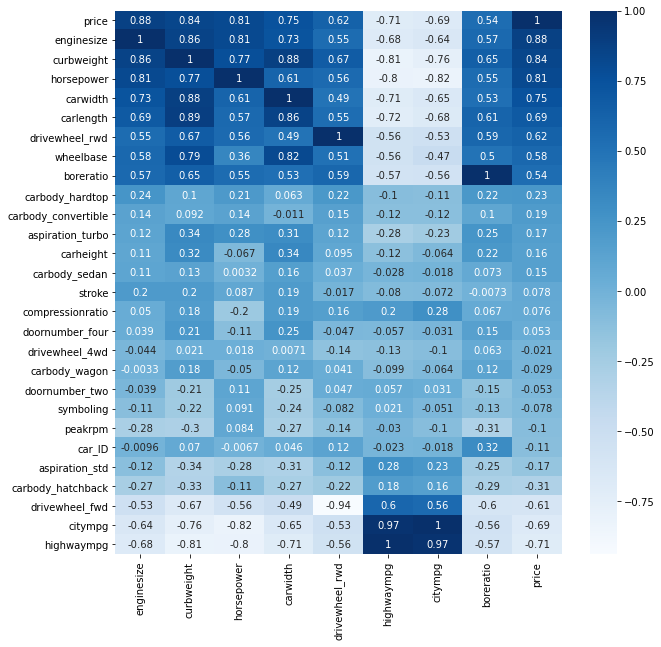

In [ ]:
# use Matplotlib to set the size of the plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))



# Create the heatmap:

# 1) Used all the {Numeric + Dummy} vars on the Y-axis.
# 2) On the X-axis, used only the 8 cols having highest correlation with the dependent var `price`: 
#    ......{got these 8 cols from cell[6]}:
sns.heatmap(carsTrain.corr()[['enginesize','curbweight','horsepower','carwidth', 
                              'drivewheel_rwd','highwaympg','citympg','boreratio',
                              'price']].sort_values(by='price', ascending=False),
            cmap='Blues', annot=True)

#### =>

* Start by looking at which vars have the highest correlation with the Dependent variable `price`. The independent vars that you select, should have a HIGH correlation with the dependent variable `price`, but it doesn't matter whether the correlation is +ve or -ve.



* When 2 INdependent variables have a high correlation with EACH OTHER, these 2 vars are said to be 'collinear'. Thus, the effect of EACH of these 2 independent vars on the Dependent variable (`price`) will be similar-- which unfortunately, DECREASES the statistical significance of EITHER collinear variable. Thus, when independent variables are found to be collinear, you must choose only ONE of them-- to be part of the regression model.

<br>
<br>
<br>
In the above heatmap, consider the {darkest blue} and {lightest blue} cells:

* Here, `enginesize`, `curbweight` have high, positive correlation with the dependent variable `price`: (0.88, 0.84)
* Here, `citympg`, `highwaymog` have high, negative correlation with the dependent variable `price`: (-0.69, -0.71)
Thus, both sets (+ve and -ve) should be considered, when selecting the vars for the model.

<br>

* However, some independent vars are correlated with the dependent var `price`, as well as with EACH OTHER:

`enginesize`, `curbweight`, `citympg`, `highwaympg`.

-- `enginesize` v/s `curbweight`: 0.86

-- `citympg` v/s `highwaympg`: 0.97


### || 5. 2)* How to test different combinations of variables: ||


#### # 5.2.1) Manually go through the diferent 'combinations' and 'number' of indep vars:

###### 5.2.1.1) An initial model that's fitted to 8 independent variables:

In [62]:
model4 = LinearRegression()
xCols = ['enginesize','curbweight','horsepower','carwidth', 'carlength',
         'drivewheel_rwd','highwaympg','citympg'] #used the same Cols that were on the x-axis of the above heatmap
        # ie, used the 8 cols that have the highest correlation with the Dependent var `price`
        # 1st 6 cols, have +ve correlation with the Dependent var `price`
        # last 2 cols, have -ve correation with the Dependent var `price`

model4.fit(carsTrain[xCols], carsTrain['price'])

model4.score(carsTest[xCols], carsTest['price'])

0.739243731429341

In [60]:
model4.score(carsTrain[xCols], carsTrain['price'])

0.8344434015448825

###### 5.2.1.2)  The initial model without the citympg column:

As`citympg` and `highwaympg` have high collinearity (0.97), removed one of them:

In [63]:
model5 = LinearRegression()
xCols = ['enginesize','curbweight','horsepower','carwidth','carlength',
         'drivewheel_rwd','highwaympg']

model5.fit(carsTrain[xCols], carsTrain['price'])
model5.score(carsTest[xCols], carsTest['price'])

0.743094490364766

In [64]:
model5.score(carsTrain[xCols], carsTrain['price'])

0.8339017954221501

#### =>
* The TestScore and TrainingScore for Model#5 (after dropping a collinear variable), are similar to that of model#4.

* Thus, dropping a collinear variable, does not improve the Score too much. Conversely, including collinear variables, does not hurt the Score.

###### 5.2.1.3) A model that's fitted to all the {Numeric} and {Dummy} variables:

Include EVERY column, except the Dependent var `price`:

(This includes the cols having LOW correlations with the Dependent var `price`)

In [66]:
model6 = LinearRegression()
xCols = carsTrain.corr().drop(columns=['price']).columns.tolist()

model6.fit(carsTrain[xCols], carsTrain['price'])
model6.score(carsTest[xCols], carsTest['price'])

0.7741309452324638

In [67]:
model6.score(carsTrain[xCols], carsTrain['price'])

0.893488927713899

* Compared to model#4 and model#5, BOTH the TestScore and TrainingScore have improved.
* But, the gap between the TestScore and TrainingScore (0.89- 0.77 = 0.12) is still larger than preferred.

* Thus, should be able to get a better result by selecting a SMALLER number of independent variables.
* But, which **smaller number** should I choose? Find this out using `scikit-learn` and pandas' `df.plot()`.

<br>
<br>

Note:
1. In general, it is better to select a SMALLER number of independent variables, than the number of Indep vars that exist--- coz using too many Indep vars results in `overfitting`-- ie, the Model has learned the trainingData too well, and has become too specific to the data. 

2. In contrast, if you use too few Indep vars, the Model will not have enough info to make accurate predictions, causing `underfitting`.

3. Thus, to produce the optimal regression model, you must select not only the right Indep vars, but also the right NUMBER of Indep vars.

#### || 5.3) How to use SciKit learn to select the variables: || 

* Select not only the right Indep vars, but also the right NUMBER of Indep vars-- is called a `feature selection` (fs) problem.

* `scikit-learn` provides `sklearn.feature_selection`.

* 

In [68]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

##### =================== 
The `fit()` method of the Feature Selection object `fs` (`fs.fit()`)-- only works on {Numeric} columns.

Thus, in `train_test_split()`, drop the non-numeric columns.

In [70]:
cars_and_Dummies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_ID               205 non-null    int64  
 1   symboling            205 non-null    int64  
 2   CarName              205 non-null    object 
 3   fueltype             205 non-null    object 
 4   enginelocation       205 non-null    object 
 5   wheelbase            205 non-null    float64
 6   carlength            205 non-null    float64
 7   carwidth             205 non-null    float64
 8   carheight            205 non-null    float64
 9   curbweight           205 non-null    float64
 10  enginetype           205 non-null    object 
 11  cylindernumber       205 non-null    object 
 12  enginesize           205 non-null    float64
 13  fuelsystem           205 non-null    object 
 14  boreratio            205 non-null    float64
 15  stroke               205 non-null    flo

In [71]:
carsTrain, carsTest = train_test_split(cars_and_Dummies_df.drop(
                            columns=['CarName','fueltype','enginelocation', # from the o/p of `df.info()` dropping all the 'object' columns
                                    'enginetype', 'cylindernumber',  
                                    'fuelsystem']), 
                            test_size=0.2, random_state=20)

##### =================== 
* The `SelectKBest()` method creates a Feature Selection object named `fs` 




In [72]:
fs = SelectKBest(score_func= mutual_info_regression, k=20)

# `k` = num of cols (ie, 'features') that you want to use in the model

# `score_func` = scoring function that is used to select these 20 features.
#               This scoring function assigns each feature a score that indicates how important that feature is, & thus, 
#               whether it should be selected.

# The `mutual_info_regression` scoring function, does an effective job of 'scoring' collinear variables. 
# To determine which scoring function is best given your dataset's characteristics, study the official documentation.


##### =================== 
* The `fit()` method of that `fs` object (ie: `fs.fit()`)-- fits the TrainingData to the `feature selection` model.

In [73]:
fs.fit(carsTrain.drop(columns=['price']), carsTrain['price'])

SelectKBest(k=20,
            score_func=<function mutual_info_regression at 0x0000023169A60310>)

##### =================== Transform the Trainingdata and Testdata, based on the results of the `fs.fit()` method:

In [74]:
x_train_fs = fs.transform(carsTrain.drop(columns=['price']))
x_test_fs = fs.transform(carsTest.drop(columns=['price']))

##### =================== 
Use the transformed data in the regression:

In [75]:
model7 = LinearRegression()

model7.fit(x_train_fs, carsTrain['price'])

model7.score(x_test_fs, carsTest['price'])

0.7730268917681576

In [76]:
model7.score(x_train_fs, carsTrain['price'])

0.8826996202377456

### =>
* Here the TestScore and TrainingScore in model#7 (after feature-selection), is similar to that in model#6 (model that is fitted to ALL the numeric and dummy variables-- not recommended, due to overfitting).

* Meaning, model#7 too overfitted, as it used too many variables (20 vars).

In [77]:
df1 = pd.DataFrame(carsTrain.drop(columns=['price']).columns, columns=['feature'])
df2 = pd.DataFrame(fs.scores_, columns=['importance'])


In [81]:
display(df1)
display(df1.shape)

,feature
0,car_ID
1,symboling
2,wheelbase
3,carlength
4,carwidth
5,carheight
6,curbweight
7,enginesize
8,boreratio
9,stroke


(27, 1)

In [79]:
display(df2.head()) # displaying the importances of only the FIRST 5 features
display(df2.shape)

,importance
0,0.439254
1,0.225003
2,0.585169
3,0.573974
4,0.676461


(27, 1)

In [82]:
importance_df = df1.join(df2)
importance_df.sort_values('importance', ascending=False) 

# importance_df.sort_values('importance', ascending=False).head()    # displaying the importances of the HIGHEST 5 features

,feature,importance
6,curbweight,0.901872
11,horsepower,0.870495
14,highwaympg,0.868522
7,enginesize,0.853681
13,citympg,0.737477
4,carwidth,0.676461
2,wheelbase,0.585169
3,carlength,0.573974
0,car_ID,0.439254
8,boreratio,0.390780


### =>
* The FS model determined that the `horsepower` feature is more important than `enginesize` , even though, in the heatmap from cell[39],  `enginesize` has a higher correlation with `price` (`enginesize v/s price` = 0.88, `horsepower v/s price` = 0.81)

* `highwaympg` and `citympg` are ranked 3rd and 5th by the FS model-- even though they have a -ve correlation with the Dependet var `price` ( -0.71 and -0.69 from cell[39])

* The top-5 features of `importance_df`, ranked here-- even though some of them have a high degree of collinearity (`highwaymg` and `citympg`).

### =>
* Because of the `importances` displayed by `sklearn's feature selector` , we no longer have to worry about WHICH features to use, we just have to determine HOW MANY of these `important` features we must use.

<br>
<br>
<br>

* For this, you can either try out different values in the `k` parameter in `SelectKBest()` (eg: k=19, k=18, k=17, k=16, ...); 

OR

put these steps in a `for` loop, and check the results for each k-value.

#### =============================================================
#### || 5.4) How to select the right NUMBER of `important` variables: ||

* Using a `for` loop to `score()` the model for varying number of features, ie varying values of `k`:

In [89]:
model = LinearRegression()
testScores_list = []
trainScores_list = []

for i in range(1, len(carsTrain.columns)):
    fs = SelectKBest(score_func=mutual_info_regression, k=i)
    fs.fit(carsTrain.drop(columns=['price']), carsTrain['price'])

    x_train_fs = fs.transform(carsTrain.drop(columns=['price']))
    x_test_fs = fs.transform(carsTest.drop(columns=['price']))

    model.fit(x_train_fs, carsTrain['price'])

    testScore = model.score(x_test_fs, carsTest['price'])
    trainScore = model.score(x_train_fs, carsTrain['price'])
    testScores_list.append(testScore)
    trainScores_list.append(trainScore)



###### =====================
* How to plot the TestScores and TrainingScores for each value of `k`, to determine the optimal value of `k`:

In [90]:
df = pd.DataFrame(data={'testScores':testScores_list, 'trainScores':trainScores_list})
df.reset_index(inplace=True)
display(df)




,index,testScores,trainScores
0,0,0.608708,0.701379
1,1,0.711521,0.774061
2,2,0.685315,0.781644
3,3,0.767383,0.815386
4,4,0.763173,0.815719
5,5,0.747073,0.822507
6,6,0.744563,0.822889
7,7,0.733167,0.824847
8,8,0.738644,0.838340
9,9,0.729937,0.838736


In [91]:
df.rename(columns={'index':'numOfFeatures'}, inplace=True)
display(df)
display(df.shape)

,numOfFeatures,testScores,trainScores
0,0,0.608708,0.701379
1,1,0.711521,0.774061
2,2,0.685315,0.781644
3,3,0.767383,0.815386
4,4,0.763173,0.815719
5,5,0.747073,0.822507
6,6,0.744563,0.822889
7,7,0.733167,0.824847
8,8,0.738644,0.838340
9,9,0.729937,0.838736


(27, 3)

,numOfFeatures,testScores,trainScores
0,1,0.608708,0.701379
1,2,0.711521,0.774061
2,3,0.685315,0.781644
3,4,0.767383,0.815386
4,5,0.763173,0.815719
5,6,0.747073,0.822507
6,7,0.744563,0.822889
7,8,0.733167,0.824847
8,9,0.738644,0.838340
9,10,0.729937,0.838736


<AxesSubplot:xlabel='numOfFeatures'>

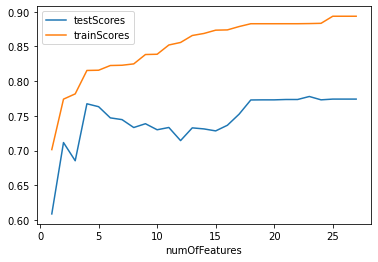

In [92]:
df['numOfFeatures'] = df['numOfFeatures'] + 1 #so that 'numOfFeatures' gets to start with '1', instead of '0'
display(df)

display(df.plot(x='numOfFeatures', y=['testScores','trainScores']))

#### =>
* TestScores start to descrease after the model reaches 4 features (ie, after `k=4`)

<AxesSubplot:xlabel='numOfFeatures'>

,numOfFeatures,testScores,trainScores,gap
0,1,0.608708,0.701379,0.092671
1,2,0.711521,0.774061,0.062540
2,3,0.685315,0.781644,0.096329
3,4,0.767383,0.815386,0.048002
4,5,0.763173,0.815719,0.052546
5,6,0.747073,0.822507,0.075434
6,7,0.744563,0.822889,0.078325
7,8,0.733167,0.824847,0.091679
8,9,0.738644,0.838340,0.099696
9,10,0.729937,0.838736,0.108798


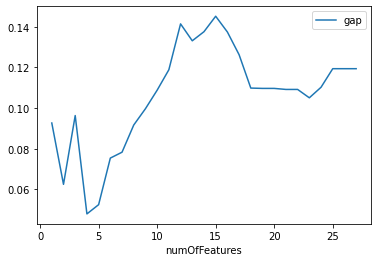

In [94]:
# Or, if you only want to plot the gap between the `testScores` and `trainingScores`, you could do it like this...
df['gap'] = df['trainScores'] - df['testScores']
display(df.plot(x='numOfFeatures', y=['gap']))

display(df) 
# to see the point at which the GAP  between the TestScore and TrainingScore INCREASES,
#     at the same time that the TrainingScore stagnates or decreases.

#### =>
* Alternatively, you can see that the GAP between the TestScores and TrainingScores, is the smallest at `k=4`.
* ie, the GAP between the TestScores and TrainingScores, `increases` after reaching 4 features. 



In [93]:
####################################################################################

CONCLUSION:

What we're looking for:
* Highest TestScore
* The smallest GAP between TestScore and TrainingScore
* the fewest features (value of `k`)

Based on these criteria, the right number of features for this regression model is `k=4`.

#### =>
Thus, the features that should be input to the model are the `four`, most `important` features:
* curbweight	-> 0.901872
* horsepower	-> 0.870495
* highwaympg	-> 0.868522
* enginesize	-> 0.853681

Note:
* The 1st of the 2 plots indicates that the model is overfitted (linegraph of the `trainingScores`) as soon as `k` gets beyond 4.
* That's coz the testScores start to go down, while the TrainScores go up.


* Although overfitting won't always be so obvious, remember that overfitting is indicated whenever the GAP (eg: plot#2 of 2) between the TestScore and TrainingScore INCREASES at the same time that the TestScore stagnates or decreases.